# Neural networks with TensorFlow

I will build a larger network that can identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

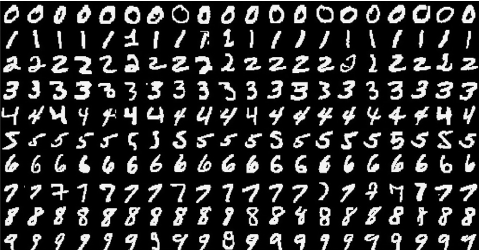

My goal is to build a neural network that can take one of these images and predict the digit in the image.

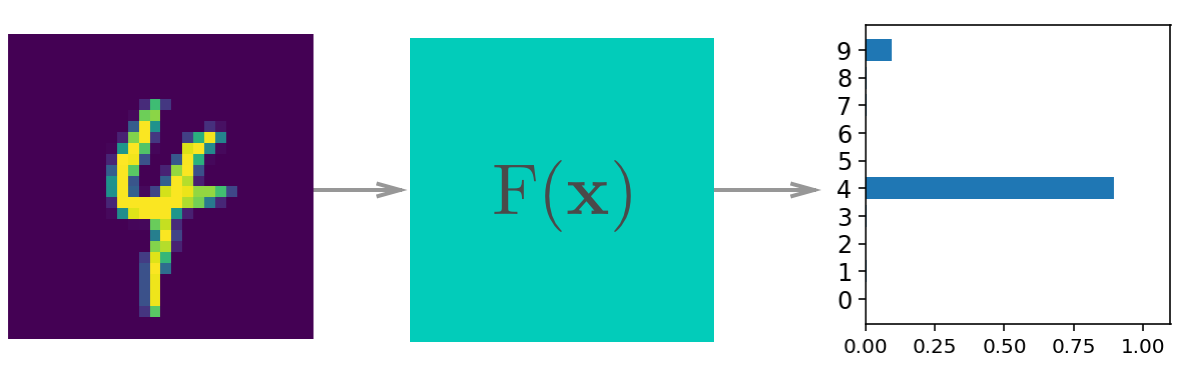

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load the Data

In [4]:
# Pipline of transformation
#transform = transforms.Compose([transforms.ToTensor(),

training_set, dataset_info = tfds.load('mnist', split='train', as_supervised = True, with_info = True)
testing_set = tfds.load('mnist', split='test', as_supervised = True, with_info = False)

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


## Create Pipeline of Transformation

In [5]:
num_training_examples = dataset_info.splits['train'].num_examples
num_testing_examples = dataset_info.splits['test'].num_examples

In [6]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

num_training_examples = dataset_info.splits['train'].num_examples

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
testing_batches = testing_set.cache().shuffle(num_testing_examples//4).batch(batch_size).map(normalize).prefetch(1)

## Visualize a Batch of Training Data

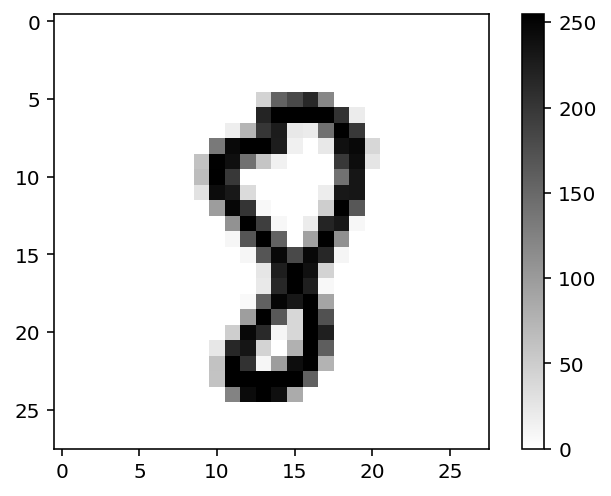

The label of this image is: 8


In [13]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)

## Define the Network Architecture

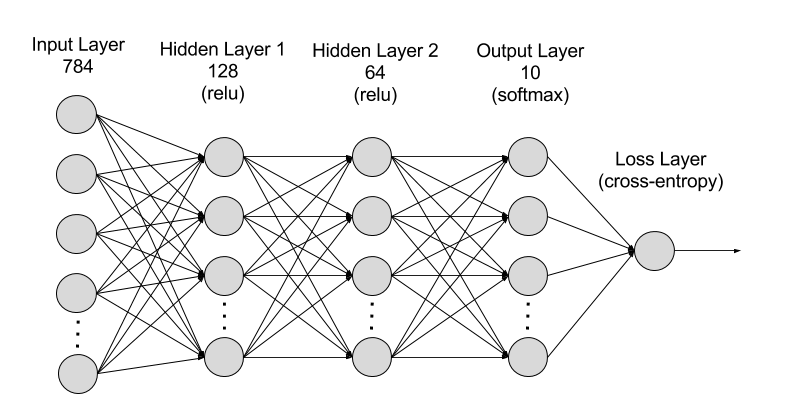

### Method1: Subclassing with TensorFlow and Keras

In [15]:
class My_Network(tf.keras.Model):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.num_classes = num_classes
    
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden_1 = tf.keras.layers.Dense(128, activation = 'relu')
        self.hidden_2 = tf.keras.layers.Dense(64, activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
    
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.output_layer(x)
    
        return x

my_model_2 = My_Network()

my_model_2.build((None, 28, 28, 1))

my_model_2.summary()

Model: "my__network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  100480    
_________________________________________________________________
dense_4 (Dense)              multiple                  8256      
_________________________________________________________________
dense_5 (Dense)              multiple                  650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [17]:
tf.keras.backend.clear_session()

### Method2:Using `tf.keras.Sequential`

In [18]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Specifiy Optimizer, Loss function and Metrics

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the Model


In [9]:
EPOCHS = 5

history = model.fit(training_batches, epochs = EPOCHS)

Epoch 1/5
938/938 [==============================] - 21s 23ms/step - loss: 0.2818 - accuracy: 0.9191
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1168 - accuracy: 0.9648
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0801 - accuracy: 0.9750
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0597 - accuracy: 0.9811
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0475 - accuracy: 0.9851


In [11]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

64/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Test the Model

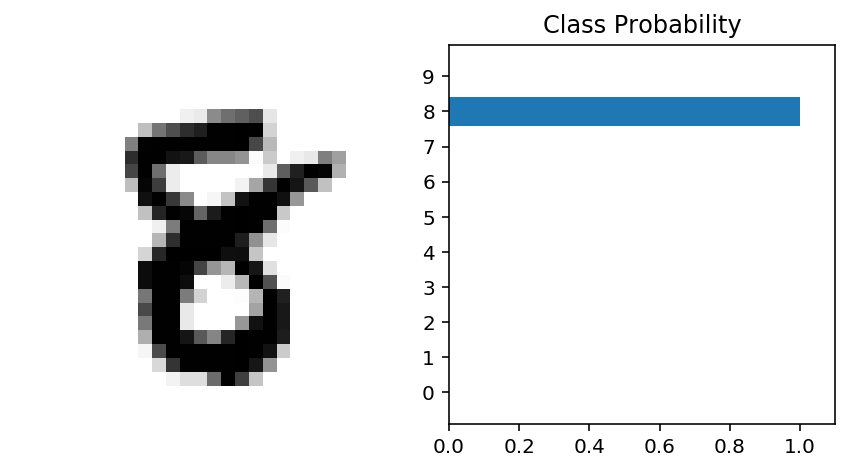

In [12]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
  
  
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()